# Imports

In [1]:
# General Imports
import os
import re
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# ML-Specific Imports
# Preprocessing Imports
from gensim.models import Word2Vec

# Analysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, PrecisionRecallDisplay, precision_recall_curve
from sklearn.model_selection import cross_val_score, KFold, train_test_split

# Tensor Flow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, LeakyReLU, Dropout
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


# Imports for Naive Bayes.
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Colab Setup & Google Drive Mounting

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Set up Google Drive.
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Machine Learning Project/work'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Final_Project_Models.ipynb']


# Data Preprocessing & Setup

## Load Data

In [4]:
raw_data_1 = pd.read_json(f"{GOOGLE_DRIVE_PATH}/../data/original_pii_dataset.json")
raw_data_2 = pd.read_json(f"{GOOGLE_DRIVE_PATH}/../data/mixtral-8x7b-v1.json")
raw_dataset = pd.concat([raw_data_1, raw_data_2], ignore_index=True)
raw_dataset = raw_dataset.sample(frac=1, random_state=0).reset_index(drop=True) # Shuffle.
raw_dataset.drop(columns=['tokens', 'trailing_whitespace'], inplace=True) # Drop 'tokens' and 'trailing_whitespace' column since they are unused.

print(f"Columns: {raw_dataset.keys()}")
raw_dataset.head()

Columns: Index(['document', 'full_text', 'labels'], dtype='object')


,document,full_text,labels
0,hhirqdovnm,Myrtle Way; https://www.twitter.com/m_way; 773...,"[B-NAME_STUDENT, I-NAME_STUDENT, O, B-URL_PERS..."
1,18404,Reflection – Storytelling\n\nChallenge\n\nOur ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,14895,Reflection of Storytelling\n\nCHALLENGE Sto...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,21468,Mind Mapping\n\nChallenge & Selection\n\nMy jo...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,14416,Using visualization as an aid to presenting ke...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## Preprocessing Functions

In [5]:
def binarize_data(data):
    """
    Updates dataframe such that labels are only 0 or 1.
    """
    for index, row in data.iterrows():
        if any(label != 'O' for label in row['labels']):
            data.loc[index, 'labels'] = 1  # Set label to 1 if 'O' is not the only element in the labels array
        else:
            data.loc[index, 'labels'] = 0  # Set label to 0 if 'O' is the only element in the labels array

    data['labels'] = data['labels'].astype(int)

    return data

In [6]:
def custom_tokenizer(text):
    """
    Tokenizes the text, treating words, '://', and other punctuation as separate tokens.
    The pattern \w+ captures word characters, [^\w\s] captures individual punctuation, and :\/\/ captures '://' for URLs.
    We are ignoring spaces, newline characters, etc.
    Then replaces all tokens that are purely numeric with '<NUM>'.
    All tokens are put in lowercase.
    """
    text = text.lower()
    tokens = re.findall(r'\w+|:\/\/|[^\w\s]', text)
    tokens = [token if not token.isdigit() else '<NUM>' for token in tokens]
    return tokens


# Example Tokenization Usage.
example_token_text = "Email:\n\njohn.doe@example.com, Phone: +123-456-7890. URL: http://example.com/path?arg=value; Another Email: jane_doe@sample.org"
example_tokens = custom_tokenizer(example_token_text)
print(example_tokens)

['email', ':', 'john', '.', 'doe', '@', 'example', '.', 'com', ',', 'phone', ':', '+', '<NUM>', '-', '<NUM>', '-', '<NUM>', '.', 'url', ':', 'http', '://', 'example', '.', 'com', '/', 'path', '?', 'arg', '=', 'value', ';', 'another', 'email', ':', 'jane_doe', '@', 'sample', '.', 'org']


In [7]:
def use_word2vec(data):
    # Collect the tokenized text documents.
    doc_texts = data['tokens'].tolist()

    # Initialize the word2vec model.
    model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4)

    # Build the vocabulary from the tokenized documents
    model.build_vocab(doc_texts)
    print(f"Vocabulary built with {len(model.wv.index_to_key)} unique tokens.")

    # Ensure vocabulary is not empty.
    if len(model.wv.index_to_key) == 0:
        raise ValueError("Vocabulary is empty. Check tokenization and min_count parameters.")

    # Train the word2vec model.
    model.train(doc_texts, total_examples=model.corpus_count, epochs=model.epochs)

    # Calculate document mean vectors and store them in a list
    document_mean_vectors = []
    for doc in doc_texts:
        # Filter words to those present in the model's vocabulary.
        valid_words = [word for word in doc if word in model.wv]

        # Calculate mean vector for the document, handle empty documents.
        if valid_words:
            word_vectors = [model.wv[word] for word in valid_words]
            document_mean_vectors.append(np.mean(word_vectors, axis=0))
        else:
            document_mean_vectors.append(np.zeros(model.vector_size))

    # Convert list of vectors to a numpy array
    return np.array(document_mean_vectors)


# Example word2vec Usage.
example_word2vec_data = {
    'tokens': [['this', 'is', 'a', 'sample', 'sentence'], ['this', 'is', 'another', 'example', 'sentence']]
}

example_word2vec_data = pd.DataFrame(example_word2vec_data)

document_vectors = use_word2vec(example_word2vec_data)
print("Document vectors:\n", document_vectors)

Vocabulary built with 7 unique tokens.
Document vectors:
 [[-1.9313125e-03  9.3046325e-04  3.0773730e-04  1.0126045e-03
  -7.5734145e-04 -1.2401232e-03  2.8874918e-03  4.2693550e-03
  -5.1834532e-03 -2.4230410e-03  6.4616918e-04 -2.7678537e-03
  -1.7599638e-03  2.8523810e-03 -3.3636615e-04 -1.9731321e-03
   3.5947736e-03  3.9047871e-03 -4.2746086e-03 -5.1471749e-03
  -1.0425893e-03 -1.4669753e-03  5.7777208e-03 -1.7462277e-03
   3.0710169e-03 -1.3190617e-03  7.6538516e-04  1.7179502e-04
  -2.8204739e-03  2.2486874e-03  4.0541538e-03 -2.5083921e-03
  -7.3176750e-04 -4.1306363e-03 -2.6340741e-03  2.0460542e-03
   2.7224307e-03 -3.1366850e-05  2.0372798e-03 -1.7122261e-03
   1.9060473e-03 -2.6760600e-03 -3.5613715e-03 -1.4925643e-03
   6.9635280e-04  3.7173007e-03 -1.7332786e-03  5.8259827e-04
  -5.8009120e-04  1.1366076e-03  7.1395823e-04 -4.9702097e-03
  -2.4356288e-03  1.5649481e-03 -3.8705268e-03 -1.7277289e-03
   3.8490728e-03 -4.1743875e-03 -4.9488693e-03 -5.4921565e-04
   4.5435317

## Preprocessing

In [8]:
# Binarize the dataset.
bin_clf_data = binarize_data(raw_dataset)

In [9]:
# Tokenize the dataset.
bin_clf_data['tokens'] = bin_clf_data['full_text'].apply(custom_tokenizer)

In [10]:
bin_clf_data[0:10]

,document,full_text,labels,tokens
0,hhirqdovnm,Myrtle Way; https://www.twitter.com/m_way; 773...,1,"[myrtle, way, ;, https, ://, www, ., twitter, ..."
1,18404,Reflection – Storytelling\n\nChallenge\n\nOur ...,0,"[reflection, –, storytelling, challenge, our, ..."
2,14895,Reflection of Storytelling\n\nCHALLENGE Sto...,0,"[reflection, of, storytelling, challenge, stor..."
3,21468,Mind Mapping\n\nChallenge & Selection\n\nMy jo...,0,"[mind, mapping, challenge, &, selection, my, j..."
4,14416,Using visualization as an aid to presenting ke...,0,"[using, visualization, as, an, aid, to, presen..."
5,15226,08 December 2016 – pvc\n\nDesign Thinking - As...,0,"[<NUM>, december, <NUM>, –, pvc, design, think..."
6,22376,Learning Launch\n\nChallenge\n\nI wanted to so...,0,"[learning, launch, challenge, i, wanted, to, s..."
7,bfjdhkjqlw,Lounis Proffitt - proffitt47\nproffitt55@iclou...,1,"[lounis, proffitt, -, proffitt47, proffitt55, ..."
8,sgvqavmupw,"Baya Miguel, 001-339-998-6153\nmiguel@outlook....",1,"[baya, miguel, ,, <NUM>, -, <NUM>, -, <NUM>, -..."
9,13504,DESIGN THINKING FOR INNOVATION\n\nFINAL ASSIGN...,0,"[design, thinking, for, innovation, final, ass..."


In [11]:
# Get Document Vectors With word2vec.
document_vectors = use_word2vec(bin_clf_data)

Vocabulary built with 48802 unique tokens.


In [12]:
print("Document Vectors Type:", document_vectors.dtype)
print("Document Vectors Shape:", document_vectors.shape)
print("Labels Type:", bin_clf_data['labels'].dtype)
print("Labels Shape:", bin_clf_data['labels'].shape)

class_counts = bin_clf_data['labels'].value_counts()
print(class_counts)

Document Vectors Type: float32
Document Vectors Shape: (9162, 100)
Labels Type: int64
Labels Shape: (9162,)
labels
0    5862
1    3300
Name: count, dtype: int64


# Set Random Seeds

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

# Models

## Neural Network

In [14]:
from keras.callbacks import Callback

class EarlyStoppingMovingAverage(Callback):
    """
    Custom Keras callback for early stopping. This callback monitors a moving average
    rather than a metric directly to help account for minor fluctuations within the training
    process.
    """
    def __init__(self, window_size=5, min_delta=0.001, patience=10, monitor='val_loss', verbose=False, restore_best_weights=True):
        super().__init__()
        self.window_size = window_size
        self.min_delta = min_delta
        self.patience = patience
        self.monitor = monitor
        self.best_weights = None
        self.best_epoch = 0
        self.wait = 0
        self.stopped_epoch = 0
        self.verbose = verbose
        self.restore_best_weights = restore_best_weights
        self.moving_average = []

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None:
            self.moving_average.append(current)
            if len(self.moving_average) > self.window_size:
                self.moving_average.pop(0)

            moving_avg_value = np.mean(self.moving_average)

            if len(self.moving_average) == self.window_size:
                if self.best_weights is None or moving_avg_value < self.best + self.min_delta:
                    self.best = moving_avg_value
                    self.best_epoch = epoch
                    self.best_weights = self.model.get_weights()
                    self.wait = 0
                else:
                    self.wait += 1
                    if self.wait >= self.patience:
                        self.stopped_epoch = epoch
                        self.model.stop_training = True
                        if self.verbose:
                            print(f"\nEpoch {epoch + 1}: Early stopping with Moving Average.")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose:
            print(f"\nEpoch {self.stopped_epoch + 1}: Early Stopping.")
        if self.restore_best_weights and self.best_weights is not None:
            self.model.set_weights(self.best_weights)


# Example Callback Creation.
# monitor = metric to monitor for early stopping.
# window_size = size of the moving average window.
# min_delta = the minimum change in the monitored metric to qualify as an improvement.
# patience = number of epochs with no improvement after which training will be stopped.
# verbose = boolean; if set to True, print early stopping information.
# restore_best_weights = boolean; if set to True, restores model weights from the epoch with the best value of the monitored metric.
early_stopping_moving_average_example = EarlyStoppingMovingAverage(
    monitor='val_accuracy',
    window_size=5,
    min_delta=0.01,
    patience=15,
    verbose=True,
    restore_best_weights=True
)

In [15]:
# Ensure data is in NumPy array format
document_vectors = np.array(document_vectors)
labels = np.array(bin_clf_data['labels'])

# Split data into training and test sets
document_vectors_train, document_vectors_test, labels_train, labels_test = train_test_split(document_vectors, labels, test_size=0.2, random_state=42)

# Configure K-Fold cross validation.
kfold = KFold(5, shuffle=True, random_state=42)

# Lists to store results for metrics.
acc_scores = []
precision_scores = []
recall_scores = []

# Use for tracking 'best' model.
best_recall = -1 # Initially set to an impossible low value for base.
best_model_weights = None # To store the best model weights.

# Train and do 5-Fold cv.
fold_no = 1
for train, test in kfold.split(document_vectors_train, labels_train):
    # Clear session to avoid early stopping and metric naming conflicts.
    K.clear_session()

    # Define the model.
    model = Sequential([
        Dense(128, input_dim=document_vectors_train.shape[1]),
        LeakyReLU(alpha=0.01),
        Dense(256),
        LeakyReLU(alpha=0.01),
        Dense(256),
        LeakyReLU(alpha=0.01),
        Dense(256),
        Dropout(.3),
        LeakyReLU(alpha=0.01),
        Dense(256),
        Dropout(.3),
        LeakyReLU(alpha=0.01),
        Dense(1, activation="sigmoid")
    ])

    # Compile the model.
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', Precision(), Recall()])

    # Define early stopping callbacks. Do this each fold.
    early_stopping_accuracy = EarlyStoppingMovingAverage(
        monitor='val_accuracy',
        window_size=5,
        min_delta=0.0025,
        patience=4,
        verbose=1,
        restore_best_weights=True)
    early_stopping_precision = EarlyStoppingMovingAverage(
        monitor='val_precision',
        window_size=5,
        min_delta=0.0025,
        patience=4,
        verbose=1,
        restore_best_weights=True)
    early_stopping_recall = EarlyStoppingMovingAverage(
        monitor='val_recall',
        window_size=5,
        min_delta=0.0025,
        patience=4,
        verbose=1,
        restore_best_weights=True)

    # Perform training.
    print(f'\nTraining for Fold {fold_no}...')

    # Fit data to model.
    history = model.fit(document_vectors_train[train], labels_train[train],
                        batch_size=64,
                        epochs=50,
                        verbose=1,
                        validation_data=(document_vectors_train[test], labels_train[test]),
                        callbacks=[early_stopping_accuracy, early_stopping_precision, early_stopping_recall])

    # Generate generalization metrics
    scores = model.evaluate(document_vectors[test], bin_clf_data['labels'][test], verbose=0)
    print(f'\nScore for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}.\n')

    # Save metrics for fold.
    acc_scores.append(scores[1])
    precision_scores.append(scores[2])
    recall_scores.append(scores[3])

    fold_no += 1


Training for Fold 1...
Epoch 1/50
92/92 [==============================] - 3s 11ms/step - loss: 0.3238 - accuracy: 0.8896 - precision: 0.9614 - recall: 0.7219 - val_loss: 0.3160 - val_accuracy: 0.8834 - val_precision: 0.9895 - val_recall: 0.6924
Epoch 2/50
92/92 [==============================] - 1s 8ms/step - loss: 0.2885 - accuracy: 0.9001 - precision: 0.9954 - recall: 0.7252 - val_loss: 0.3097 - val_accuracy: 0.8861 - val_precision: 1.0000 - val_recall: 0.6924
Epoch 3/50
92/92 [==============================] - 1s 8ms/step - loss: 0.2877 - accuracy: 0.9011 - precision: 0.9987 - recall: 0.7257 - val_loss: 0.3103 - val_accuracy: 0.8840 - val_precision: 0.9921 - val_recall: 0.6924
Epoch 4/50
92/92 [==============================] - 1s 8ms/step - loss: 0.2824 - accuracy: 0.9006 - precision: 0.9929 - recall: 0.7285 - val_loss: 0.3068 - val_accuracy: 0.8847 - val_precision: 0.9947 - val_recall: 0.6924
Epoch 5/50
92/92 [==============================] - 1s 8ms/step - loss: 0.2804 - accura

### Results

#### Summary Statistics

In [16]:
# Calculate and print summary statistics for each metric
def print_formatted_summary(scores, metric_name):
    print(f"Average {np.mean(scores):.4f} {metric_name} with a standard deviation of {np.std(scores):.4f}")
    print(f"max: {np.max(scores)}, min: {np.min(scores)}.\n")

print(f"----- 5-Fold Cross Validation -----")
print_formatted_summary(acc_scores, "Accuracy")
print_formatted_summary(precision_scores, "Precision")
print_formatted_summary(recall_scores, "Recall")

----- 5-Fold Cross Validation -----
Average 0.8975 Accuracy with a standard deviation of 0.0052
max: 0.9051841497421265, min: 0.8907849788665771.

Average 0.9923 Precision with a standard deviation of 0.0048
max: 1.0, min: 0.9871134161949158.

Average 0.7193 Recall with a standard deviation of 0.0165
max: 0.7471697926521301, min: 0.6996197700500488.



#### Accuracy, Precision, Recall (Over Epoch) Plots

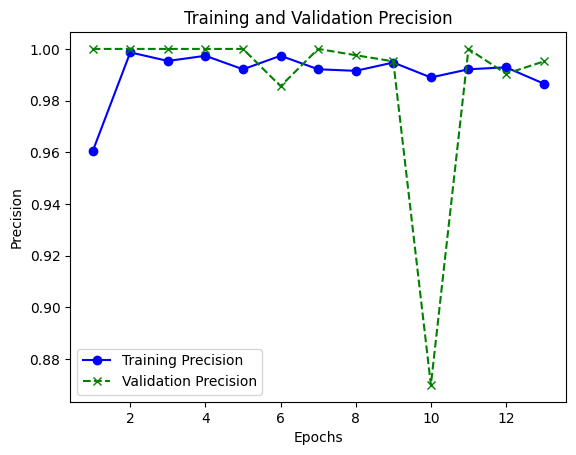

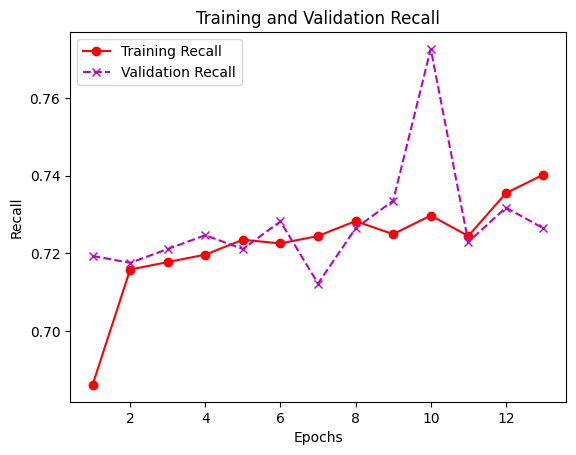

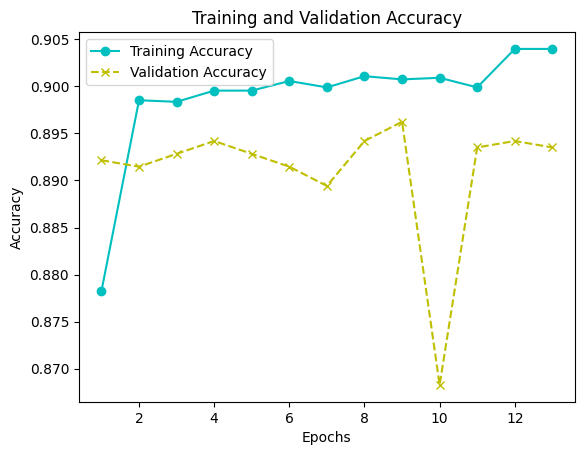

In [17]:
precision = history.history['precision']
recall = history.history['recall']
accuracy = history.history['accuracy']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(precision) + 1)

# Plot Precision Over Epochs
plt.figure()
plt.plot(epochs, precision, 'b', label='Training Precision', linestyle='-', marker='o')
plt.plot(epochs, val_precision, 'g', label='Validation Precision', linestyle='--', marker='x')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot Recall Over Epochs
plt.figure()
plt.plot(epochs, recall, 'r', label='Training Recall', linestyle='-', marker='o')
plt.plot(epochs, val_recall, 'm', label='Validation Recall', linestyle='--', marker='x')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plotting Accuracy Over Epochs
plt.figure()
plt.plot(epochs, accuracy, 'c', label='Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, val_accuracy, 'y', label='Validation Accuracy', linestyle='--', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Classification Report & Confusion Matrix

58/58 [==============================] - 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

     Non-PII       0.86      0.99      0.92      1183
         PII       0.98      0.70      0.82       650

    accuracy                           0.89      1833
   macro avg       0.92      0.85      0.87      1833
weighted avg       0.90      0.89      0.88      1833

Confusion Matrix:
 [[1173   10]
 [ 192  458]]


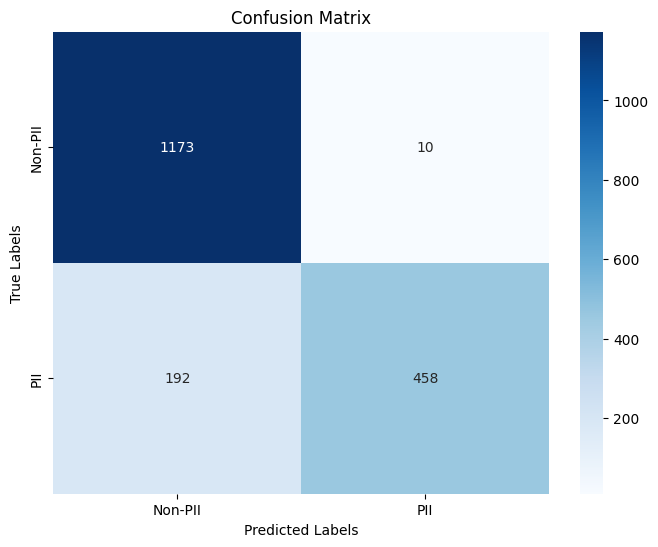

In [18]:
# Load the best model based on recall.
predictions = model.predict(document_vectors_test)
predicted_classes = (predictions > 0.5).astype(int)

# Generate classification report
class_report = classification_report(labels_test, predicted_classes, target_names=['Non-PII', 'PII'])
print("Classification Report:\n", class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(labels_test, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Plot fancy confusion matrix :D
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-PII', 'PII'], yticklabels=['Non-PII', 'PII'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Precision-Recall Plot

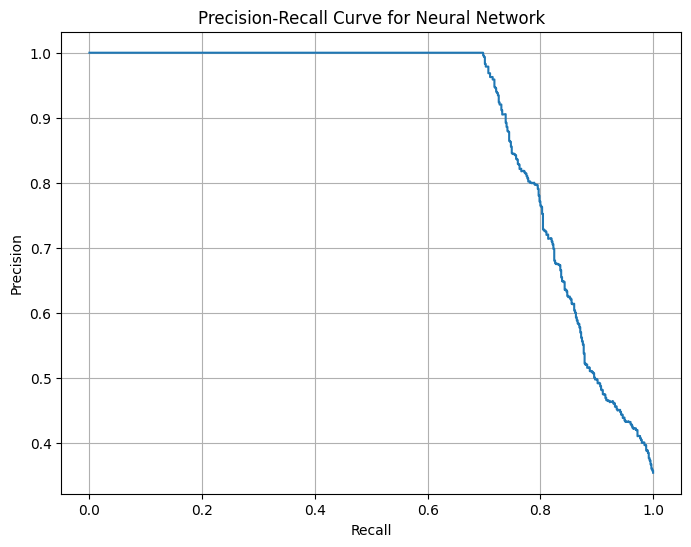

In [19]:
precision, recall, thresholds = precision_recall_curve(labels_test, predictions)

# Plot the precision-recall plot.
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve')
plt.title('Precision-Recall Curve for Neural Network')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Naive Bayes

In [20]:
# Convert tokenized text to strings
X = [' '.join(tokens) for tokens in bin_clf_data['tokens']]
y = bin_clf_data['labels']

In [21]:
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split test and training data (with 80-20 split).
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=0)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [22]:
# Perform 5-fold cross validation on the model.
acc_cv_score = cross_val_score(nb_classifier, X_train, y_train, cv=5, scoring="accuracy")
precision_cv_score = cross_val_score(nb_classifier, X_train, y_train, cv=5, scoring="precision")
recall_cv_score = cross_val_score(nb_classifier, X_train, y_train, cv=5, scoring="recall")
f1_cv_score = cross_val_score(nb_classifier, X_train, y_train, cv=5, scoring="f1_macro")

print("----- 5-Fold Cross Validation -----")
print("Average %0.4f accuracy with a standard deviation of %0.4f" % (acc_cv_score.mean(), acc_cv_score.std()))
print(f"max: {acc_cv_score.max()}, min: {acc_cv_score.min()}.\n")
print("Average %0.4f precision with a standard deviation of %0.4f" % (precision_cv_score.mean(), precision_cv_score.std()))
print(f"max: {precision_cv_score.max()}, min: {precision_cv_score.min()}.\n")
print("Average %0.4f recall with a standard deviation of %0.4f" % (recall_cv_score.mean(), recall_cv_score.std()))
print(f"max: {recall_cv_score.max()}, min: {recall_cv_score.min()}.\n")
print("Average %0.4f f1-score with a standard deviation of %0.4f" % (f1_cv_score.mean(), f1_cv_score.std()))
print(f"max: {f1_cv_score.max()}, min: {f1_cv_score.min()}.\n")

----- 5-Fold Cross Validation -----
Average 0.8917 accuracy with a standard deviation of 0.0050
max: 0.8976109215017065, min: 0.8826739427012278.

Average 0.9844 precision with a standard deviation of 0.0044
max: 0.9895561357702349, min: 0.9773869346733668.

Average 0.7118 recall with a standard deviation of 0.0145
max: 0.7339622641509433, min: 0.6886792452830188.

Average 0.8737 f1-score with a standard deviation of 0.0064
max: 0.881718497020221, min: 0.8622917872707612.



----- Test Data Results -----
Accuracy: 0.9012547735951991

Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      1184
           1       0.99      0.73      0.84       649

    accuracy                           0.90      1833
   macro avg       0.93      0.86      0.88      1833
weighted avg       0.91      0.90      0.90      1833



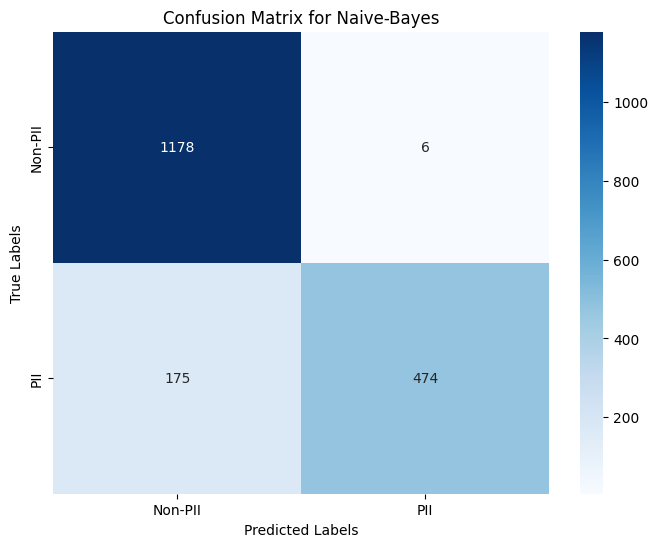

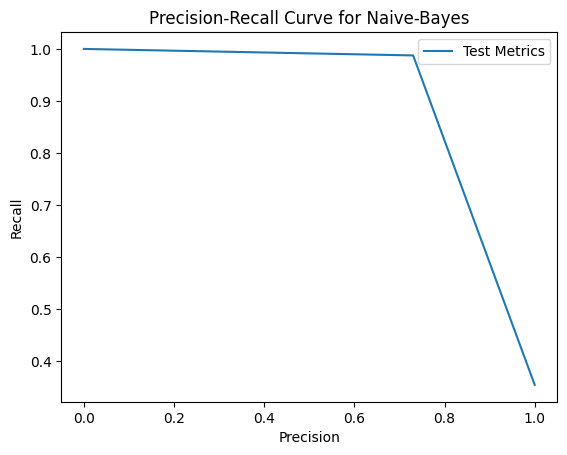

In [23]:
# Evaluate model using test data.
predictions = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
clf_report = classification_report(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

# Output results.
print("----- Test Data Results -----")
print(f'Accuracy: {accuracy}\n')
print(f'Report:\n{clf_report}')

# Plot fancy confusion matrix :D
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-PII', 'PII'], yticklabels=['Non-PII', 'PII'])
plt.title('Confusion Matrix for Naive-Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute precision and recall for plotting
precision_test, recall_test, thresholds = precision_recall_curve(y_test, predictions)

# Plot the precision-recall curve for the test set
plt.plot(recall_test, precision_test, label="Test Metrics")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall Curve for Naive-Bayes")
plt.legend()
plt.show()

## Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LeakyReLU, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

#from imblearn.ensemble import BalancedRandomForestClassifier - didnt work

vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split test and training data (with 80-20 split).
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
}

#Train RF classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train, y_train)

# Prepare for cross-validation
rf_classifier = RandomizedSearchCV(rf_classifier, param_distributions, n_iter=5, scoring='recall', cv=3, random_state=0).fit(X_val, y_val)

In [ ]:
# Perform 5-fold cross validation on the model.
acc_cv_score = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring="accuracy")
precision_cv_score = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring="precision")
recall_cv_score = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring="recall")
f1_cv_score = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring="f1_macro")

print("----- 5-Fold Cross Validation -----")
print("Average %0.4f accuracy with a standard deviation of %0.4f" % (acc_cv_score.mean(), acc_cv_score.std()))
print(f"max: {acc_cv_score.max()}, min: {acc_cv_score.min()}.\n")
print("Average %0.4f precision with a standard deviation of %0.4f" % (precision_cv_score.mean(), precision_cv_score.std()))
print(f"max: {precision_cv_score.max()}, min: {precision_cv_score.min()}.\n")
print("Average %0.4f recall with a standard deviation of %0.4f" % (recall_cv_score.mean(), recall_cv_score.std()))
print(f"max: {recall_cv_score.max()}, min: {recall_cv_score.min()}.\n")
print("Average %0.4f f1-score with a standard deviation of %0.4f" % (f1_cv_score.mean(), f1_cv_score.std()))
print(f"max: {f1_cv_score.max()}, min: {f1_cv_score.min()}.\n")

In [ ]:
#Predict the labels for test data
y_pred = rf_classifier.predict(X_test)

#Evaluate this classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# Plot fancy confusion matrix :D
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-PII', 'PII'], yticklabels=['Non-PII', 'PII'])
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute precision and recall for plotting
precision_test, recall_test, thresholds = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve for the test set
plt.plot(recall_test, precision_test, label="Test Metrics")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Test for Random Forest Classifier")
plt.legend()
plt.show()

In [ ]:
feature_names = bin_clf_data.columns.tolist()
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_importance_df = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], color='b', align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## Logistic Regression

In [ ]:
# Initializing the Model and Datasets
from sklearn.linear_model import LogisticRegression
classifier_model = LogisticRegression(random_state=42, solver='liblinear')

# Getting the count from each sentence in terms of frequency
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split test and training data (with 80-20 split).
X_train, X_test, y_train, y_test = train_test_split(document_vectors, y, test_size=0.2, random_state=0)

# Training and testing the Model
classifier_model.fit(X_train, y_train)

y_pred = classifier_model.predict(X_test)
y_predproba = classifier_model.predict_proba(X_test)

###Plotting and Evaluating the Model

In [ ]:
# Perform 5-fold cross validation on the model.
acc_cv_score = cross_val_score(classifier_model, X_train, y_train, cv=5, scoring="accuracy")
precision_cv_score = cross_val_score(classifier_model, X_train, y_train, cv=5, scoring="precision")
recall_cv_score = cross_val_score(classifier_model, X_train, y_train, cv=5, scoring="recall")
f1_cv_score = cross_val_score(classifier_model, X_train, y_train, cv=5, scoring="f1_macro")

print("----- 5-Fold Cross Validation -----")
print("Average %0.4f accuracy with a standard deviation of %0.4f" % (acc_cv_score.mean(), acc_cv_score.std()))
print(f"max: {acc_cv_score.max()}, min: {acc_cv_score.min()}.\n")
print("Average %0.4f precision with a standard deviation of %0.4f" % (precision_cv_score.mean(), precision_cv_score.std()))
print(f"max: {precision_cv_score.max()}, min: {precision_cv_score.min()}.\n")
print("Average %0.4f recall with a standard deviation of %0.4f" % (recall_cv_score.mean(), recall_cv_score.std()))
print(f"max: {recall_cv_score.max()}, min: {recall_cv_score.min()}.\n")
print("Average %0.4f f1-score with a standard deviation of %0.4f" % (f1_cv_score.mean(), f1_cv_score.std()))
print(f"max: {f1_cv_score.max()}, min: {f1_cv_score.min()}.\n")

In [ ]:
#Evaluate this classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# Plot fancy confusion matrix :D
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-PII', 'PII'], yticklabels=['Non-PII', 'PII'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute precision and recall for plotting
precision_test, recall_test, thresholds = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve for the test set
plt.plot(recall_test, precision_test, label="Test Metrics")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Test for Logistic Regression")
plt.legend()
plt.show()

## Support Vector Machine (I suppose)

In [ ]:
# Initializing the Model and Datasets
from sklearn.svm import SVC
classifier_model = SVC(kernel='sigmoid', random_state=42)

# Getting the count from each sentence in terms of frequency
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split test and training data (with 80-20 split).
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=0)

# Training and testing the Model
classifier_model.fit(X_train, y_train)

y_pred = classifier_model.predict(X_test)

### Plotting and Evaluating SVM

In [ ]:
# Perform 5-fold cross validation on the model.
acc_cv_score = cross_val_score(classifier_model, X_train, y_train, cv=5, scoring="accuracy")
precision_cv_score = cross_val_score(classifier_model, X_train, y_train, cv=5, scoring="precision")
recall_cv_score = cross_val_score(classifier_model, X_train, y_train, cv=5, scoring="recall")
f1_cv_score = cross_val_score(classifier_model, X_train, y_train, cv=5, scoring="f1_macro")

print("----- 5-Fold Cross Validation -----")
print("Average %0.4f accuracy with a standard deviation of %0.4f" % (acc_cv_score.mean(), acc_cv_score.std()))
print(f"max: {acc_cv_score.max()}, min: {acc_cv_score.min()}.\n")
print("Average %0.4f precision with a standard deviation of %0.4f" % (precision_cv_score.mean(), precision_cv_score.std()))
print(f"max: {precision_cv_score.max()}, min: {precision_cv_score.min()}.\n")
print("Average %0.4f recall with a standard deviation of %0.4f" % (recall_cv_score.mean(), recall_cv_score.std()))
print(f"max: {recall_cv_score.max()}, min: {recall_cv_score.min()}.\n")
print("Average %0.4f f1-score with a standard deviation of %0.4f" % (f1_cv_score.mean(), f1_cv_score.std()))
print(f"max: {f1_cv_score.max()}, min: {f1_cv_score.min()}.\n")

In [ ]:
#Evaluate this classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# Plot fancy confusion matrix :D
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-PII', 'PII'], yticklabels=['Non-PII', 'PII'])
plt.title('Confusion Matrix for a Support Vector Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute precision and recall for plotting
precision_test, recall_test, thresholds = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve for the test set
plt.plot(recall_test, precision_test, label="Test Metrics")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Test for Support Vector Classifier")
plt.legend()
plt.show()

# They're are about as good as Random Forest Classifier